# Imports and functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt


2024-02-03 20:03:03.917409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 20:03:03.965708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 20:03:03.965739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 20:03:03.967131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 20:03:03.974788: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import torchvision
import engine
import engine_boosted
import engine_boosted_multi
import helper_functions

In [3]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [ ]:
torch.set_num_threads(20)

In [4]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy using sklearn
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [5]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [6]:
kernel = {
    'ATF2': [10] ,
    'ATF3' : [10] ,
    'CEBPB' : [10] ,
    'CREB1' : [8] ,
    'CTCF' : [15] ,
    'E2F4' : [13] ,
    'EGR1' : [10] ,
    'EFL1' : [9] ,
    'ELK1' : [9] ,
    'FOS' : [8] ,
    'FOXA1' : [8] ,
    'GABPA' : [10] ,
    'JUN' : [14] ,
    'JUND' : [11] ,
    'MAFK' : [10] ,
    'MAX' : [6] ,
    'MAZ' : [8] ,
    'MXI1' : [6] ,
    'MYC' : [8] ,
    'NRF1' : [11] ,
    'RELA' : [10] ,
    'REST' : [20] ,
    'RFX5' : [14] ,
    'SP1' : [9] ,
    'SRF' : [16] ,
    'TCF7L2' : [9] ,
    'TCF12' : [7] ,
    'TEAD4' : [8] ,
    'USF1' : [10] ,
    'USF2' : [10] ,
    'YY1' : [12] ,
    'ZBTB33' : [10] ,
    'ZNF274' : [12]
}

In [7]:
tf_class = {
    'ATF2': 0,
    'ATF3': 1,
    'CEBPB': 2,
    'CREB1': 3,
    'CTCF': 4,
    'E2F4': 5,
    'EGR1': 6,
    'EFL1': 7,
    'ELK1': 8,
    'FOS': 9,
    'FOXA1': 10,
    'GABPA': 11,
    'JUN': 12,
    'JUND': 13,
    'MAFK': 14,
    'MAX': 15,
    'MAZ': 16,
    'MXI1': 17,
    'MYC': 18,
    'NRF1': 19,
    'RELA': 20,
    'REST': 21,
    'RFX5': 22,
    'SP1': 23,
    'SRF': 24,
    'TCF7L2': 25,
    'TCF12': 26,
    'TEAD4': 27,
    'USF1': 28,
    'USF2': 29,
    'YY1': 30,
    'ZBTB33': 31,
    'ZNF274': 32
}

# Set up device agnostic code

In [8]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
import pandas as pd

# Read the list of TFs from the file
tf_list_path = '/mnt/raid1/thalassini/home/Downloads/target_names_6.txt'
with open(tf_list_path, 'r') as file:
    tf_list = file.read().splitlines()

# Define the directory where the CSV files for each TF are located
base_directory = '/mnt/raid1/thalassini/home/filtered_fimo_chrom_200/'

# Combine data for each TF and write to a single CSV file
for tf in tf_list:
    file_path = f'{base_directory}{tf.upper()}/datasets/data.csv'
    
    try:
        df = pd.read_csv(file_path)
        
        # Add a column to identify the TF
        df['TF'] = tf
        
        # Append data to the master DataFrame or create it if it doesn't exist
        if 'master_df' in locals():
            master_df = pd.concat([master_df, df], ignore_index=True)
        else:
            master_df = df
    except FileNotFoundError:
        print(f"File not found for TF: {tf}")

# Save the combined DataFrame to a new CSV file
output_csv_path = '/mnt/raid1/thalassini/home/tf_data/combined_6_data.csv'
master_df.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")


File not found for TF: RCOR1
Combined data saved to /mnt/raid1/thalassini/home/tf_data/combined_6_data.csv


In [10]:
master_df

,chrom,data,class,TF
0,chr1,CTCCTTTTTCCCCCTCTGCCACAACCTCTAAATACTGAGGGCCCCA...,1,ATF2
1,chr1,TATAGCAATCTGAATCCTTGTGCTAAACTTAATTGTCGTTGTCGTC...,1,ATF2
2,chr6,AAAACCAAAACAAGAAGTCGGTCTCCTCTTTTTATATAATAGTTTA...,1,ATF2
3,chr4,TTAGGTCATGCACACTGAACTGAAACTGAGATGAATGACATCATCA...,1,ATF2
4,chr11,GAACAGAGGCTCAGGCAGCTGAAGTAACGTGCCTAAGGTCACATGG...,1,ATF2
...,...,...,...,...
1204211,chr5,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,ZNF274
1204212,chr19,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,ZNF274
1204213,chr19,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,ZNF274
1204214,chr1,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,ZNF274


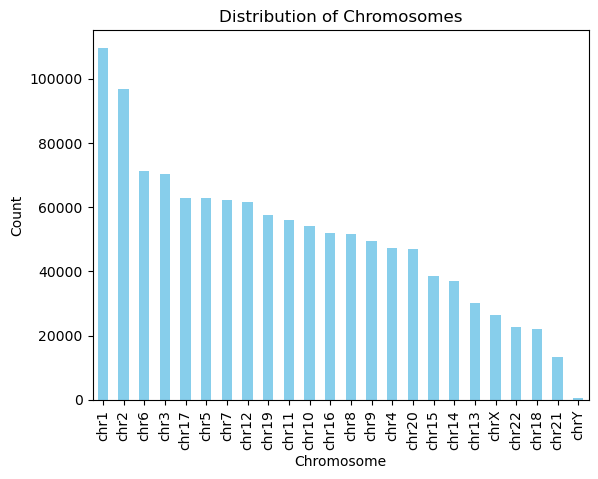

In [11]:
chromosome_counts = master_df['chrom'].value_counts()

# Plotting the histogram
chromosome_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Count')
plt.show()

In [12]:
print("Unique values in 'TF' column before mapping:", master_df['TF'].unique())


Unique values in 'TF' column before mapping: ['ATF2' 'ATF3' 'CEBPB' 'CREB1' 'CTCF' 'E2F4' 'EGR1' 'ELF1' 'ELK1' 'FOS'
 'FOXA1' 'GABPA' 'JUN' 'JUND' 'MAFK' 'MAX' 'MAZ' 'MXI1' 'MYC' 'NRF1'
 'RELA' 'REST' 'RFX5' 'SP1' 'SRF' 'TCF12' 'TCF7L2' 'TEAD4' 'USF1' 'USF2'
 'YY1' 'ZBTB33' 'ZNF274']


In [13]:

# Apply the mapping to the 'TF' column
master_df['TF'] = master_df['TF'].map(tf_class)

# Drop rows with NaN values in the 'TF' column
master_df = master_df.dropna(subset=['TF'])

# Convert the 'TF' column to integers
master_df['TF'] = master_df['TF'].astype(int)
master_df

/tmp/ipykernel_1042729/3393081513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['TF'] = master_df['TF'].astype(int)


,chrom,data,class,TF
0,chr1,CTCCTTTTTCCCCCTCTGCCACAACCTCTAAATACTGAGGGCCCCA...,1,0
1,chr1,TATAGCAATCTGAATCCTTGTGCTAAACTTAATTGTCGTTGTCGTC...,1,0
2,chr6,AAAACCAAAACAAGAAGTCGGTCTCCTCTTTTTATATAATAGTTTA...,1,0
3,chr4,TTAGGTCATGCACACTGAACTGAAACTGAGATGAATGACATCATCA...,1,0
4,chr11,GAACAGAGGCTCAGGCAGCTGAAGTAACGTGCCTAAGGTCACATGG...,1,0
...,...,...,...,...
1204211,chr5,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,32
1204212,chr19,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,32
1204213,chr19,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,32
1204214,chr1,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,32


In [14]:
# Select chromosomes for test set (e.g., 'chr1' and 'chr2')
test_chromosomes = ['chr1', 'chr2']
test_df = master_df[master_df['chrom'].isin(test_chromosomes)]

# Select chromosomes for training set (excluding 'chr1' and 'chr2')
train_df = master_df[~master_df['chrom'].isin(test_chromosomes)]

# Print the shapes of train and test sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (982801, 4)
Test set shape: (204215, 4)


# Sequence length inspection and normalization

Max length:200, Min length: 200


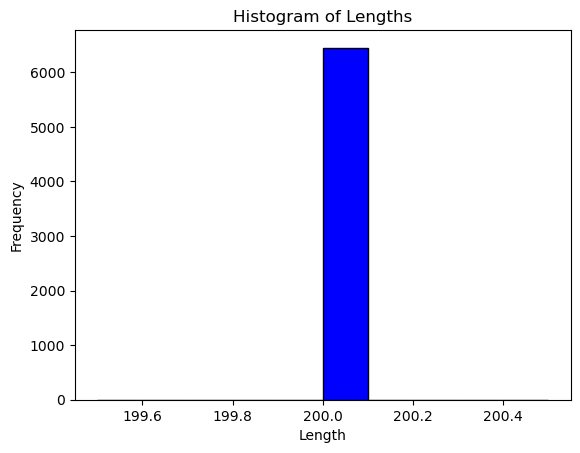

In [15]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [16]:
lengths= [len(item) for item in df['data']]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:200, Min length: 200


# Create train, valid, test Dataloaders


In [17]:
X=[one_hot_encode(sequence) for sequence in train_df['data']]

In [18]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [19]:
X.shape

torch.Size([982801, 200, 4])

In [20]:
#y=np.array(df['TF'])
y=np.array(train_df['class'])

y[:3]

array([1, 1, 1])

In [21]:
y = torch.from_numpy(y).type(torch.float)

In [22]:
train_loader, valid_loader = helper_functions.make_2loaders(X,y)

In [23]:
X=[one_hot_encode(sequence) for sequence in test_df['data']]
X = torch.from_numpy(np.array(X)).type(torch.float)
y=np.array(test_df['class'])
y = torch.from_numpy(y).type(torch.float)
test_loader = helper_functions.make_loader(X,y)

# Construct a 1 layer CNN with Maxpooling and Dropout

In [24]:
class Conv_v0(torch.nn.Module):

    def __init__(self):
        super(Conv_v0, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels=5, kernel_size=17)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        
        self.dropout = torch.nn.Dropout(p=0.25) 
        #in_features = 108 for 200kb, 588 for 1kb, 1188 for 2kb
        self.fc =  torch.nn.LazyLinear(out_features=2)
        #self.sigmoid = torch.nn.Sigmoid() will not be used since its intergraded in BCEWithLogitsLoss()
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
        x = self.fc(x)
        #x = self.softmax(x)
        #x = self.sigmoid(x)
        return x


# Set up loss function and optimizer

In [26]:
from torch.optim import lr_scheduler


In [27]:
torch.manual_seed(42)

# Initialize model instance
model = Conv_v0()

#loss_fn = nn.BCEWithLogitsLoss(weight=weights)
loss_fn = nn.BCEWithLogitsLoss()

# Define oprimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define exponetntial lr with lr_scheduler
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

/mnt/raid1/thalassini/home/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [28]:
# Check number of classes in the model
num_classes_model = model.fc.out_features  # Adjust accordingly


In [29]:
num_classes_model

2

In [30]:
results, _ = engine_boosted.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=valid_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=800,
                                                  device=device)


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6459 | train_bal_acc: 0.6163 | train_mcc: 0.2448 | train_auroc: 0.6527  |  valid_loss: 0.6334 | valid_bal_acc: 0.6313 | valid_mcc: 0.2739  |  valid_auroc: 0.6755
Epoch: 2 | train_loss: 0.6316 | train_bal_acc: 0.6337 | train_mcc: 0.2824 | train_auroc: 0.6772  |  valid_loss: 0.6255 | valid_bal_acc: 0.6389 | valid_mcc: 0.2901  |  valid_auroc: 0.6869
Epoch: 3 | train_loss: 0.6273 | train_bal_acc: 0.6362 | train_mcc: 0.2841 | train_auroc: 0.6836  |  valid_loss: 0.6228 | valid_bal_acc: 0.6370 | valid_mcc: 0.2792  |  valid_auroc: 0.6907
Epoch: 4 | train_loss: 0.6251 | train_bal_acc: 0.6373 | train_mcc: 0.2852 | train_auroc: 0.6860  |  valid_loss: 0.6200 | valid_bal_acc: 0.6425 | valid_mcc: 0.2962  |  valid_auroc: 0.6939
Epoch: 5 | train_loss: 0.6239 | train_bal_acc: 0.6379 | train_mcc: 0.2858 | train_auroc: 0.6876  |  valid_loss: 0.6191 | valid_bal_acc: 0.6454 | valid_mcc: 0.3092  |  valid_auroc: 0.6951
Epoch: 6 | train_loss: 0.6232 | train_bal_acc: 0.6383 | train_mcc

Epoch: 45 | train_loss: 0.6194 | train_bal_acc: 0.6414 | train_mcc: 0.2932 | train_auroc: 0.6933  |  valid_loss: 0.6150 | valid_bal_acc: 0.6482 | valid_mcc: 0.3136  |  valid_auroc: 0.6997
Epoch: 46 | train_loss: 0.6195 | train_bal_acc: 0.6418 | train_mcc: 0.2938 | train_auroc: 0.6937  |  valid_loss: 0.6149 | valid_bal_acc: 0.6457 | valid_mcc: 0.3038  |  valid_auroc: 0.6985
Epoch: 47 | train_loss: 0.6195 | train_bal_acc: 0.6412 | train_mcc: 0.2924 | train_auroc: 0.6937  |  valid_loss: 0.6155 | valid_bal_acc: 0.6485 | valid_mcc: 0.3181  |  valid_auroc: 0.7000
Epoch: 48 | train_loss: 0.6193 | train_bal_acc: 0.6418 | train_mcc: 0.2939 | train_auroc: 0.6939  |  valid_loss: 0.6149 | valid_bal_acc: 0.6449 | valid_mcc: 0.3007  |  valid_auroc: 0.6990
Epoch: 49 | train_loss: 0.6193 | train_bal_acc: 0.6412 | train_mcc: 0.2926 | train_auroc: 0.6939  |  valid_loss: 0.6153 | valid_bal_acc: 0.6432 | valid_mcc: 0.2932  |  valid_auroc: 0.6996
Epoch: 50 | train_loss: 0.6192 | train_bal_acc: 0.6420 | tra

Epoch: 89 | train_loss: 0.6176 | train_bal_acc: 0.6435 | train_mcc: 0.2974 | train_auroc: 0.6958  |  valid_loss: 0.6130 | valid_bal_acc: 0.6479 | valid_mcc: 0.3097  |  valid_auroc: 0.7019
Epoch: 90 | train_loss: 0.6176 | train_bal_acc: 0.6437 | train_mcc: 0.2976 | train_auroc: 0.6960  |  valid_loss: 0.6131 | valid_bal_acc: 0.6470 | valid_mcc: 0.3064  |  valid_auroc: 0.7015
Epoch: 91 | train_loss: 0.6175 | train_bal_acc: 0.6432 | train_mcc: 0.2967 | train_auroc: 0.6960  |  valid_loss: 0.6132 | valid_bal_acc: 0.6465 | valid_mcc: 0.3031  |  valid_auroc: 0.7016
Epoch: 92 | train_loss: 0.6178 | train_bal_acc: 0.6438 | train_mcc: 0.2979 | train_auroc: 0.6957  |  valid_loss: 0.6129 | valid_bal_acc: 0.6475 | valid_mcc: 0.3083  |  valid_auroc: 0.7018
Epoch: 93 | train_loss: 0.6177 | train_bal_acc: 0.6432 | train_mcc: 0.2966 | train_auroc: 0.6955  |  valid_loss: 0.6136 | valid_bal_acc: 0.6490 | valid_mcc: 0.3171  |  valid_auroc: 0.7019
Epoch: 94 | train_loss: 0.6174 | train_bal_acc: 0.6439 | tra

Epoch: 133 | train_loss: 0.6172 | train_bal_acc: 0.6436 | train_mcc: 0.2976 | train_auroc: 0.6964  |  valid_loss: 0.6129 | valid_bal_acc: 0.6480 | valid_mcc: 0.3107  |  valid_auroc: 0.7014
Epoch: 134 | train_loss: 0.6173 | train_bal_acc: 0.6437 | train_mcc: 0.2976 | train_auroc: 0.6961  |  valid_loss: 0.6130 | valid_bal_acc: 0.6466 | valid_mcc: 0.3056  |  valid_auroc: 0.7002
Epoch: 135 | train_loss: 0.6174 | train_bal_acc: 0.6433 | train_mcc: 0.2971 | train_auroc: 0.6957  |  valid_loss: 0.6130 | valid_bal_acc: 0.6477 | valid_mcc: 0.3087  |  valid_auroc: 0.7013
Epoch: 136 | train_loss: 0.6171 | train_bal_acc: 0.6436 | train_mcc: 0.2978 | train_auroc: 0.6962  |  valid_loss: 0.6132 | valid_bal_acc: 0.6460 | valid_mcc: 0.3027  |  valid_auroc: 0.7000
Epoch: 137 | train_loss: 0.6172 | train_bal_acc: 0.6437 | train_mcc: 0.2979 | train_auroc: 0.6963  |  valid_loss: 0.6131 | valid_bal_acc: 0.6461 | valid_mcc: 0.3020  |  valid_auroc: 0.7011
Epoch: 138 | train_loss: 0.6174 | train_bal_acc: 0.6437

Epoch: 177 | train_loss: 0.6173 | train_bal_acc: 0.6432 | train_mcc: 0.2968 | train_auroc: 0.6958  |  valid_loss: 0.6131 | valid_bal_acc: 0.6488 | valid_mcc: 0.3140  |  valid_auroc: 0.7015
Epoch: 178 | train_loss: 0.6171 | train_bal_acc: 0.6434 | train_mcc: 0.2974 | train_auroc: 0.6962  |  valid_loss: 0.6133 | valid_bal_acc: 0.6493 | valid_mcc: 0.3186  |  valid_auroc: 0.7016
Epoch: 179 | train_loss: 0.6172 | train_bal_acc: 0.6430 | train_mcc: 0.2965 | train_auroc: 0.6964  |  valid_loss: 0.6128 | valid_bal_acc: 0.6468 | valid_mcc: 0.3053  |  valid_auroc: 0.7012
Epoch: 180 | train_loss: 0.6171 | train_bal_acc: 0.6432 | train_mcc: 0.2969 | train_auroc: 0.6960  |  valid_loss: 0.6128 | valid_bal_acc: 0.6468 | valid_mcc: 0.3056  |  valid_auroc: 0.7013
Epoch: 181 | train_loss: 0.6172 | train_bal_acc: 0.6432 | train_mcc: 0.2968 | train_auroc: 0.6959  |  valid_loss: 0.6127 | valid_bal_acc: 0.6478 | valid_mcc: 0.3094  |  valid_auroc: 0.7014
Epoch: 182 | train_loss: 0.6171 | train_bal_acc: 0.6433

Epoch: 221 | train_loss: 0.6171 | train_bal_acc: 0.6433 | train_mcc: 0.2971 | train_auroc: 0.6960  |  valid_loss: 0.6132 | valid_bal_acc: 0.6455 | valid_mcc: 0.2999  |  valid_auroc: 0.7005
Epoch: 222 | train_loss: 0.6171 | train_bal_acc: 0.6432 | train_mcc: 0.2970 | train_auroc: 0.6958  |  valid_loss: 0.6128 | valid_bal_acc: 0.6473 | valid_mcc: 0.3059  |  valid_auroc: 0.7015
Epoch: 223 | train_loss: 0.6171 | train_bal_acc: 0.6436 | train_mcc: 0.2980 | train_auroc: 0.6962  |  valid_loss: 0.6127 | valid_bal_acc: 0.6484 | valid_mcc: 0.3126  |  valid_auroc: 0.7013
Epoch: 224 | train_loss: 0.6172 | train_bal_acc: 0.6433 | train_mcc: 0.2972 | train_auroc: 0.6955  |  valid_loss: 0.6128 | valid_bal_acc: 0.6472 | valid_mcc: 0.3068  |  valid_auroc: 0.7011
Early stopping after 224 epochs


In [31]:
range(len(results["train_loss"]))

range(0, 224)

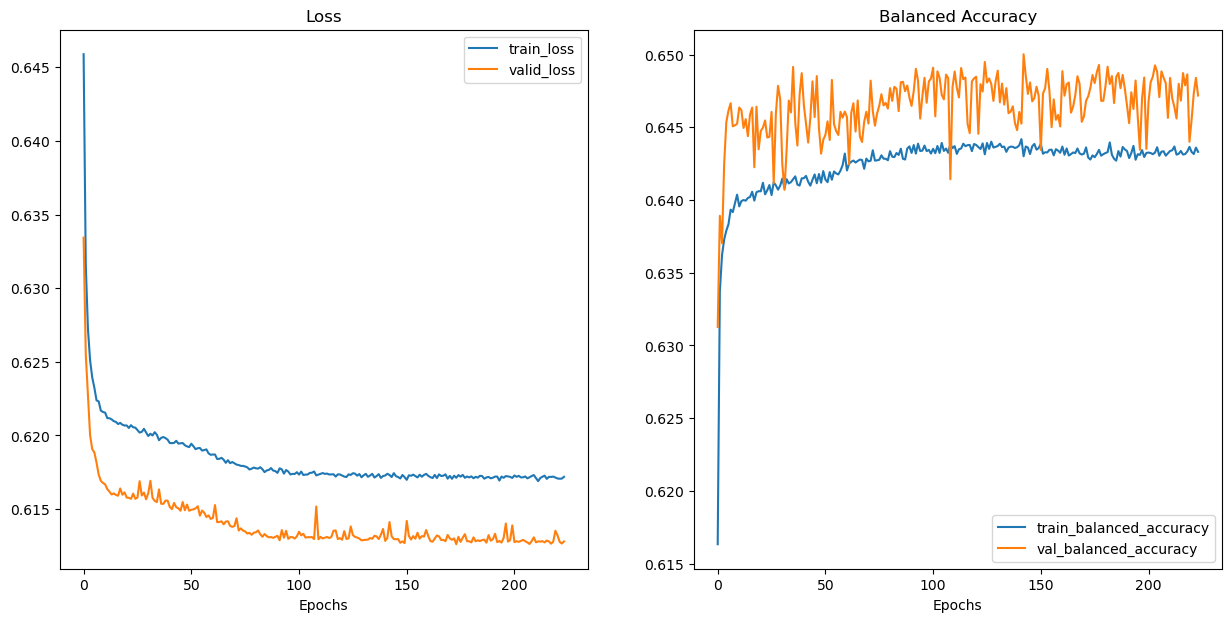

In [36]:
helper_functions.plot_loss_curves(results)
plt.savefig(f'All_TFs_CNN1_ADAM_BCEWithLogits_KERNEL=10_seq=200b.png')

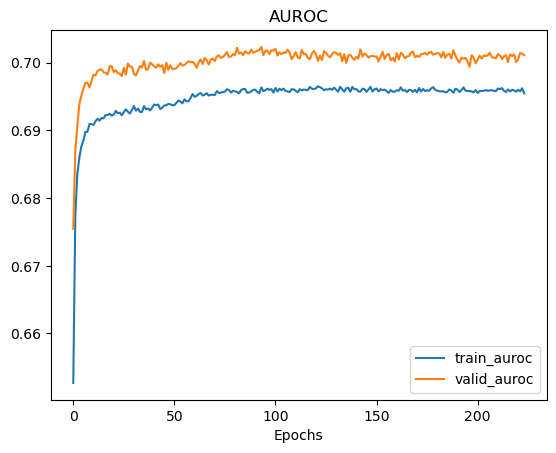

In [37]:
helper_functions.plot_auroc(results)

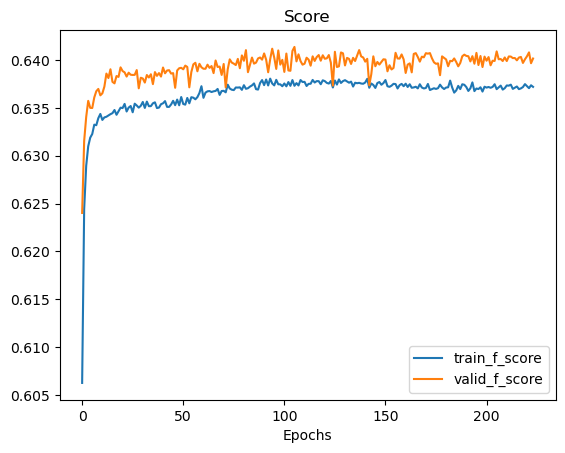

In [38]:
helper_functions.plot_f_score(results)

In [ ]:
test_results = engine_boosted.test_step(model = model,
                                        dataloader = test_loader,
                                        loss_fn = loss_fn,
                                        device =device)

In [ ]:
test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc = test_results[0], test_results[1], test_results[2], test_results[3],test_results[4], test_results[5]



print("Perfomance on held out test set")
print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    